## Import Files, Libraries and Packages

In [20]:
#import files
%run PythonETLDUNE.ipynb

#import library
import pandas as pd

# 1. ETL functions to get Data:

This part's goal is to get the data for analytics, using my self defined ETL functions from the PythonETLDUNE.ipynb jupyternotebook file. The file involves functions with different tasks, including:
- get data from Dune by Dune API
- load and save data into csv file
- transform or process data: filling null values with 0, order the date and drop unwanted column

The data I have queried from Dune Analytics platform includes dex trading data on the Binance Smart Chain blockchain which includes 8 variables:
1. token: token trading name
2. contract_address: the trading token contract address
3. day: the trading day when the data is recorded
4. trading_volume: daily trading volume of a single cryptocurrency
5. trading_pairs: token trading pair
6. total_traders: number of traders trade that token on a particular day
7. average_trading_size: average trading volume per transaction
8. daily_price: token daily price

In the query, I have already filtered out some outliers such as:
- unlaunched token with price = 0
- daily token trading volume < 10000 USD
- number of daily traders >= 2 (to avoid token traded by the deployer)

Therefore, the queried dataset will somehow be able to avoid noises and unwanted data entries which might cost more data storage.

In [6]:
#raw_df = extract_from_dune('Nl1ackC1HGp5Z5WtW6SxmHP8FvigIv9q', 5829327)
#load into excel file for further use
#load("/Users/nguyennhunamdo/Documents/portfolioproject/DuneAnalytics/BSC_dex_data_analysis/bsc_dex.csv",raw_df)
raw_df = extract_from_csv("/Users/nguyennhunamdo/Documents/portfolioproject/DuneAnalytics/BSC_dex_data_analysis/bsc_dex.csv")
processed_df = transform(raw_df)

In [33]:
total_daily_volume = processed_df.groupby('day')['trading_volume'].sum().reset_index(name='total_volume')
# Merge total daily volume back into processed_df and calculate market share
processed_df = processed_df.merge(total_daily_volume, on='day', how='left')
processed_df['market_share'] = (processed_df['trading_volume'] / processed_df['total_volume'] * 100).fillna(0)

# 2. EAD:

### 2.1 Filter "tiny cap" or "shit coin::

Filtering workflow:
Create monthly_stats and daily_stats -> extract tokens name which fail the criteria -> create new db which exclude rows with that token names

The purpose of this step is to filter out cryptocurrencies with fake volume or token with lack of liquidity based on this criteria:
- average monthly trading_pairs < 5
- average monthly traders < 100
- average monthly trading_volume < 30000 USD

In [7]:
#Monthly stats
monthly_stats = aggregate_to_monthly(processed_df)

/var/folders/7q/z507l7t92qqgwb28b_xschk80000gn/T/ipykernel_35356/3158910561.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['day'].dt.to_period('M')


In [8]:
#extract unqualified token name by Month
#use the self-defined function: unqualified_token(df, volume_threshold, trader_threshold, trading_pair_threshold)
unqualified_token_list  = unqualified_token(monthly_stats, 20000, 100, 2)

In [24]:
#create filtered df
filtered_df = processed_df[~processed_df['token'].isin(unqualified_token_list)]

In [26]:
#create price and volume differences
filtered_df['vol_lag1'] = filtered_df.groupby('token')['trading_volume'].shift(1)
filtered_df['price_lag1'] = filtered_df.groupby('token')['daily_price'].shift(1)
filtered_df['volume_growth'] = filtered_df.groupby('token')['trading_volume'].pct_change().fillna(0) * 100
filtered_df['price_growth'] = filtered_df.groupby('token')['daily_price'].pct_change().fillna(0) * 100

/var/folders/7q/z507l7t92qqgwb28b_xschk80000gn/T/ipykernel_35356/2225556967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['vol_lag1'] = filtered_df.groupby('token')['trading_volume'].shift(1)
/var/folders/7q/z507l7t92qqgwb28b_xschk80000gn/T/ipykernel_35356/2225556967.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['price_lag1'] = filtered_df.groupby('token')['daily_price'].shift(1)
/var/folders/7q/z507l7t92qqgwb28b_xschk80000gn/T/ipykernel_35356/2225556967.py:4: SettingWith

In [28]:
filtered_df = transform(filtered_df)

/var/folders/7q/z507l7t92qqgwb28b_xschk80000gn/T/ipykernel_35356/3469083356.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myDf['day'] = pd.to_datetime(myDf['day'])


In [ ]:
filtered_df['potential'] = 

### 2.2 Distribution and correlation:

In [14]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13885 entries, 0 to 23341
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   token             13885 non-null  object             
 1   contract_address  13885 non-null  object             
 2   day               13885 non-null  datetime64[ns, UTC]
 3   trading_volume    13885 non-null  float64            
 4   trading_pairs     13885 non-null  int64              
 5   total_traders     13885 non-null  int64              
 6   avg_trading_size  13885 non-null  float64            
 7   daily_price       13885 non-null  float64            
 8   month             13885 non-null  period[M]          
 9   vol_lag1          13827 non-null  float64            
 10  price_lag1        13827 non-null  float64            
 11  volume_growth     13885 non-null  float64            
 12  price_growth      13885 non-null  float64            
dtypes: dat

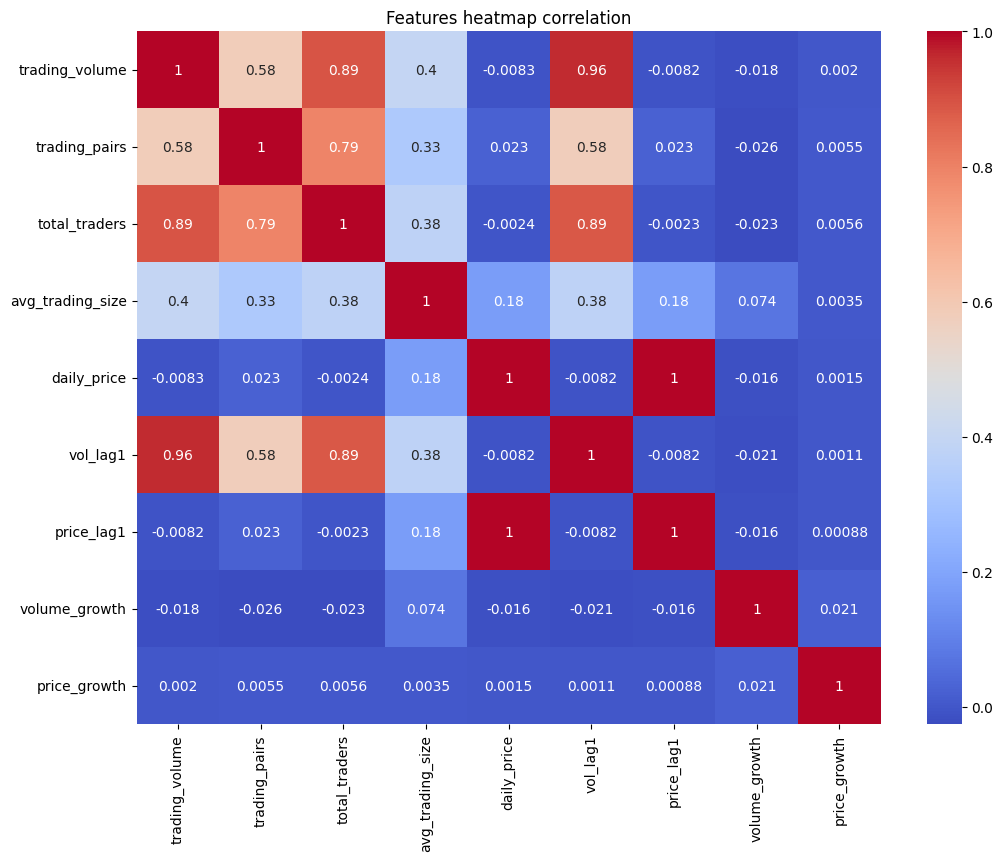

In [31]:
pairwise_corr(filtered_df)